# Faster R-CNN - OPTİMİZE MOD (2 Epoch)

Bu notebook, 300 resim ve 2 epoch ile eğitilecek şekilde yapılandırılmıştır.

**Ayarlar:**
- **Veri Sayısı:** 300 Resim
- **Resim Boyutu:** 600x600 (Hız İçin)
- **Epoch:** 2


In [36]:
import os
import torch
import torchvision
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.transforms import functional as F

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Kullanılan cihaz: {device}')

Kullanılan cihaz: cpu


## Veri Hazırlığı

In [37]:
# --- AYARLAR ---
root_dir = r"C:\Users\gozde\OneDrive\Masaüstü"
images_dir = os.path.join(root_dir, "images")
csv_path = os.path.join(root_dir, "train.csv")
TARGET_SIZE = (600, 600)

try:
    col_names = ['filename', 'xmin', 'ymin', 'xmax', 'ymax', 'class', 'width', 'height']
    df = pd.read_csv(csv_path, header=None, names=col_names)
    df['filename'] = df['filename'].astype(str).str.replace('test', 'train')
    
    # Dosya Kontrolü
    df['exists'] = df['filename'].apply(lambda x: os.path.exists(os.path.join(images_dir, x)))
    df = df[df['exists']]
    
    # --- LİMİT: 300 Resim ---
    limit = 300
    unique_files = df['filename'].unique()
    if len(unique_files) > limit:
        selected = unique_files[:limit]
        df = df[df['filename'].isin(selected)]
    
    print(f"Eğitimde Kullanılacak Resim Sayısı: {df['filename'].nunique()}")

except Exception as e:
    print(f"Hata: {e}")

Eğitimde Kullanılacak Resim Sayısı: 300


## Dataset Sınıfı

In [38]:
class ProductDataset(Dataset):
    def __init__(self, dataframe, image_dir, target_size=(600, 600)):
        self.df = dataframe
        self.image_dir = image_dir
        self.target_size = target_size
        self.image_ids = self.df['filename'].unique()
        self.classes = self.df['class'].unique().tolist()
        self.class_to_idx = {cls: i+1 for i, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        records = self.df[self.df['filename'] == image_id]
        image_path = os.path.join(self.image_dir, image_id)
        
        image = Image.open(image_path).convert("RGB")
        w_old, h_old = image.size
        
        image = image.resize(self.target_size, resample=Image.BILINEAR)
        w_new, h_new = self.target_size
        
        x_scale = w_new / w_old
        y_scale = h_new / h_old
        
        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        boxes[:, 0] *= x_scale
        boxes[:, 1] *= y_scale
        boxes[:, 2] *= x_scale
        boxes[:, 3] *= y_scale
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        labels = torch.as_tensor([self.class_to_idx[c] for c in records['class']], dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        target["area"] = area
        target["iscrowd"] = torch.zeros((len(boxes),), dtype=torch.int64)

        return F.to_tensor(image), target

def collate_fn(batch):
    return tuple(zip(*batch))

if 'df' in locals() and len(df) > 0:
    dataset = ProductDataset(df, images_dir, target_size=TARGET_SIZE)
    data_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
    print("Dataset Hazır.")
else:
    print("Veri yok.")

Dataset Hazır.


## Eğitim (2 Epoch)

In [39]:
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

if 'dataset' in locals() and len(dataset) > 0:
    num_classes = len(dataset.classes) + 1 
    model = get_model(num_classes)
    model.to(device)
    
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

    # --- GÜNCELLEME: 2 Epoch ---
    num_epochs = 2
    loss_history = []

    print("Eğitim Başladı...")
    try:
        for epoch in range(num_epochs):
            model.train()
            epoch_loss = 0
            count = 0
            for images, targets in data_loader:
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                
                optimizer.zero_grad()
                losses.backward()
                optimizer.step()
                
                val_loss = losses.item()
                loss_history.append(val_loss)
                epoch_loss += val_loss
                
                count += 1
                if count % 20 == 0:
                    print(f"Epoch: {epoch+1} | Adım: {count} | Loss: {val_loss:.4f}")
            
            print(f"--- Epoch {epoch+1} Tamamlandı. Ort. Loss: {epoch_loss/len(data_loader):.4f} ---")
            lr_scheduler.step()
            
        torch.save(model.state_dict(), os.path.join(root_dir, 'faster_rcnn_model.pth'))
        print("Eğitim Bitti, Model Kaydedildi!")
        
    except Exception as e:
        print(f"Hata: {e}")

C:\Users\gozde\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\gozde\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Eğitim Başladı...
Epoch: 1 | Adım: 20 | Loss: 1.8298
Epoch: 1 | Adım: 40 | Loss: 7.4954
Epoch: 1 | Adım: 60 | Loss: 5.0834
Epoch: 1 | Adım: 80 | Loss: 1.8554
Epoch: 1 | Adım: 100 | Loss: 1.8083
Epoch: 1 | Adım: 120 | Loss: 1.8885
Epoch: 1 | Adım: 140 | Loss: 1.8563
--- Epoch 1 Tamamlandı. Ort. Loss: 2.6000 ---
Epoch: 2 | Adım: 20 | Loss: 1.6224
Epoch: 2 | Adım: 40 | Loss: 1.6974
Epoch: 2 | Adım: 60 | Loss: 6.4853
Epoch: 2 | Adım: 80 | Loss: 1.6963
Epoch: 2 | Adım: 100 | Loss: 1.5963
Epoch: 2 | Adım: 120 | Loss: 1.6958
Epoch: 2 | Adım: 140 | Loss: 1.5390
--- Epoch 2 Tamamlandı. Ort. Loss: 2.4650 ---
Eğitim Bitti, Model Kaydedildi!


## Sonuç Görselleştirme

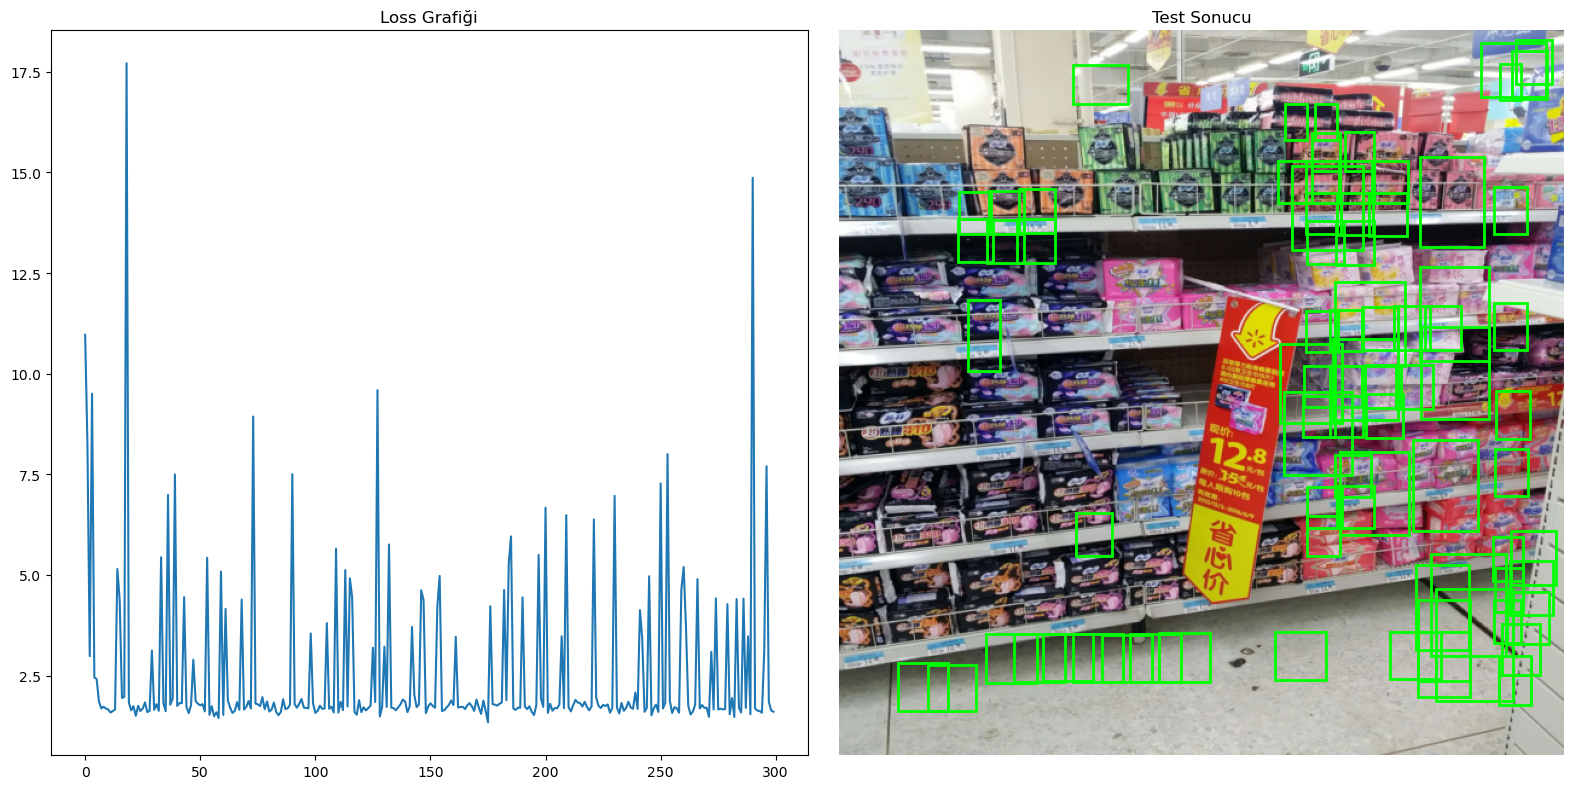

In [40]:
def visualize_results(model, dataset, loss_history, device):
    model.eval()
    if len(dataset) == 0: return
    
    idx = np.random.randint(0, len(dataset))
    img, target = dataset[idx]
    
    with torch.no_grad():
        prediction = model([img.to(device)])[0]
    
    img_display = img.permute(1, 2, 0).cpu().numpy()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    if loss_history:
        ax1.plot(loss_history, label='Loss', color='tab:blue')
        ax1.set_title(f'Loss Grafiği')
    
    ax2.imshow(img_display)
    ax2.set_title(f'Test Sonucu')
    ax2.axis('off')
    
    boxes = prediction['boxes'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()
    
    score_threshold = 0.3
    for i, box in enumerate(boxes):
        if scores[i] > score_threshold:
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='#00FF00', facecolor='none')
            ax2.add_patch(rect)
            
    plt.tight_layout()
    plt.show()

if 'loss_history' in locals() and len(loss_history) > 0:
    visualize_results(model, dataset, loss_history, device)